initial data

In [14]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date, timedelta
import statistics as st

filename = "data_preparation/cleaned_data_file.csv"
df = pd.read_csv(filename, sep=",")

startYear = 2011
endYear = 2021

dates = ["01.01", "24.02", "01.05", "23.06", "24.06", "20.08", "24.12", "25.12", "31.12"] #Non moving holiday dates
#dates = ["24.06", "25.06"]
#dates = ["23.12", "24.12", "25.12"]
#dates = ["31.12", "01.01"]
groups = [["01.01", "02.01"], ["23.06", "24.06", "25.06"], ["23.12", "24.12", "25.12"]]

functions

In [15]:
def addHolidays(holidays, source, holidaydates, start, end):

    for d in holidaydates:
        for year in range(start, end + 1):
            sd = str(d) + "." + str(year)
            entry = source.loc[source["Date"] == sd]
            holidays = pd.concat([holidays, entry])

    return holidays


def getHolidayName(d):

    holidays = {
        "01.01": "New Year's Day",
        "24.02": "Independence day",
        "01.05": "Spring Holiday",
        "23.06": "Victory Day",
        "24.06": "Midsummer day",
        "20.08": "Restoration of Independence Day",
        "24.12": "Christmas Eve",
        "25.12": "Christmas",
        "26.12": "Christmas 2",
        "31.12": "New Year's eve"
    }

    if d in holidays.keys():
        return holidays.get(d)
    else:
        return "-"


def movingHolidays(start, end):
    movingholidaydates = {"Good Friday": [], "Easter": [], "Pentecost": []}

    for y in range(start, end + 1):
        #Following code is from https://www.assa.org.au/edm#Calculator
        first_dig = y // 100  # first 2 digits of year
        remain_19 = y % 19  # remainder of year / 19

        # calculate PFM date
        temp = (first_dig - 15) // 2 + 202 - 11 * remain_19

        if first_dig in [21, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 38]:
            temp -= 1
        elif first_dig in [33, 36, 37, 39, 40]:
            temp -= 2
        temp %= 30

        t_a = temp + 21
        if temp == 29:
            t_a -= 1
        if temp == 28 and remain_19 > 10:
            t_a -= 1

        # find the next Sunday
        t_b = (t_a - 19) % 7

        t_c = (40 - first_dig) % 4
        if t_c == 3:
            t_c += 1
        if t_c > 1:
            t_c += 1

        temp = y % 100
        t_d = (temp + temp // 4) % 7

        t_e = ((20 - t_b - t_c - t_d) % 7) + 1
        d = t_a + t_e

        if d > 31:
            d -= 31
            m = 4
        else:
            m = 3

        easter = date(y, m, d)
        goodfriday = easter - timedelta(2)
        pentecost = easter + timedelta(49)

        movingholidaydates["Good Friday"].append(goodfriday.strftime("%d.%m.%Y"))
        movingholidaydates["Pentecost"].append(pentecost.strftime("%d.%m.%Y"))
        movingholidaydates["Easter"].append(easter.strftime("%d.%m.%Y"))

    return movingholidaydates

Adding DM column aka dd.mm and year

In [16]:
movingholidays = movingHolidays(startYear, endYear)

nonholiday_df= df.copy()
holidaydf = addHolidays(pd.DataFrame(), nonholiday_df, dates, startYear, endYear)
holidaystats_df = holidaydf.copy()

holidaystats_df["Day"], holidaystats_df["Month"], holidaystats_df["Year"] = holidaydf["Date"].str.split(".").str

holidaystats_df = holidaystats_df.sort_values(by=["Year", "Month", "Day"])

holidaystats_df["DM"] = holidaystats_df["Day"] + "." + holidaystats_df["Month"]
holidaystats_df = holidaystats_df.drop("Day", axis=1)
holidaystats_df = holidaystats_df.drop("Month", axis=1)

nonholiday_df["Day"], nonholiday_df["Month"], nonholiday_df["Year"] = nonholiday_df["Date"].str.split(".").str

nonholiday_df = nonholiday_df.sort_values(by=["Year", "Month", "Day"])

nonholiday_df["DM"] = nonholiday_df["Day"] + "." + nonholiday_df["Month"]
nonholiday_df = nonholiday_df.drop("Day", axis=1)
nonholiday_df = nonholiday_df.drop("Month", axis=1)

holidaystats_df = holidaystats_df.sort_values("DM")

C:\Users\annut\AppData\Local\Temp\ipykernel_8836\3689864089.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  holidaystats_df["Day"], holidaystats_df["Month"], holidaystats_df["Year"] = holidaydf["Date"].str.split(".").str
C:\Users\annut\AppData\Local\Temp\ipykernel_8836\3689864089.py:15: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  nonholiday_df["Day"], nonholiday_df["Month"], nonholiday_df["Year"] = nonholiday_df["Date"].str.split(".").str


Number of accidents on holidays

In [17]:
holidayNames = []
holiday_dict = {}

midsummer_d = ["-", "Midsummer Day", "-"]
midsummer = {}
christmas_d = ["-", "Christmas Eve", "-"]
christmas = {}
newyear_d = ["New Year's Day", "-"]
newyear = {}

for d in dates:
    name = getHolidayName(d)
    holidayNames.append(name)

for movingHoliday in movingholidays.keys():
    holidayNames.append(movingHoliday)

for year in range(startYear+1, endYear+1):
    holiday_dict[year] = []
    midsummer[year] = []
    christmas[year] = []
    newyear[year] = []

    for d in dates:
        v = holidaystats_df[holidaystats_df["Year"] == str(year)]
        v = v[v["DM"] == d]
        holiday_dict[year].append(v.value_counts().sum())


    for i in range(len(groups)):
        group = groups[i]
        for date in group:
            v = nonholiday_df[nonholiday_df["Year"] == str(year)]
            v = v[v["DM"] == date]
            if i == 0:
                newyear[year].append(v.value_counts().sum())
            if i == 1:
                midsummer[year].append(v.value_counts().sum())
            if i == 2:
                christmas[year].append(v.value_counts().sum())


for movingHoliday in movingholidays.keys():
    year = startYear + 1
    movingdates = movingholidays[movingHoliday][1:]

    for date in movingdates:
        v = nonholiday_df[nonholiday_df["Date"] == date]
        count = v.value_counts().sum()
        holiday_dict[year].append(count)
        year += 1


accidentCount_df = pd.DataFrame.from_dict(holiday_dict, orient="index", columns=holidayNames)
christmasCount = pd.DataFrame.from_dict(christmas, orient="index", columns=christmas_d)
midsummerCount = pd.DataFrame.from_dict(midsummer, orient="index", columns=midsummer_d)
newyearCount = pd.DataFrame.from_dict(newyear, orient="index", columns=newyear_d)

Dataframe of the number of accidents on each day for each year

In [18]:
dates_dict = {}
datelist = []

y = 2020
for month in range(1, 13):
    for day in range(1, 32):
        try:
            d = datetime.date(y, month, day)
            strD = d.strftime("%d.%m")
            datelist.append(strD)
        except ValueError:
            pass

for year in range(startYear+1, endYear+1):
    dates_dict[year] = []
    yearDF = nonholiday_df[nonholiday_df["Year"] == str(year)]
    for month in range(1, 13):
        for day in range(1, 32):
            try:
                d = datetime.date(year, month, day)
                strD = d.strftime("%d.%m")
                v = yearDF[yearDF["DM"] == strD]
                dates_dict[year].append(v.value_counts().sum())
            except ValueError:
                if day == 29:
                    dates_dict[year].append(np.nan)
                pass

allAccidentCount_df = pd.DataFrame.from_dict(dates_dict, orient="index", columns=datelist)

allAccidentCount_df

,01.01,02.01,03.01,04.01,05.01,06.01,07.01,08.01,09.01,10.01,...,22.12,23.12,24.12,25.12,26.12,27.12,28.12,29.12,30.12,31.12
2012,3,3,1,4,4,1,2,6,3,4,...,3,2,1,1,1,0,3,6,1,3
2013,2,2,4,2,0,2,3,2,5,6,...,3,7,1,4,3,4,2,0,3,0
2014,5,2,1,4,0,1,3,4,3,5,...,7,4,3,1,3,5,0,2,1,1
2015,3,3,4,3,4,4,1,6,4,0,...,4,4,2,2,1,1,1,0,2,1
2016,2,0,3,2,4,3,4,1,1,1,...,2,7,2,3,2,3,5,0,4,5
2017,0,2,5,3,7,1,1,5,2,2,...,5,7,1,2,1,3,6,4,1,0
2018,3,2,1,1,6,2,5,1,1,5,...,2,5,4,4,2,1,3,1,1,3
2019,2,4,1,2,6,0,2,4,3,0,...,1,1,2,1,1,4,3,2,0,2
2020,3,3,6,2,0,2,2,1,7,4,...,6,1,0,7,4,0,6,0,4,2
2021,3,4,3,0,1,1,1,2,0,1,...,0,5,4,3,4,1,1,6,6,3


Dataframes necessary for the following plots

In [19]:
years = list(allAccidentCount_df.index.values)
medians = []
holiday_m = []
christmas_m = []
midsummer_m = []
newyear_m = []

means = []
holiday_means = []
christmas_means = []
midsummer_means = []
newyear_means = []

for year in years:
    accidents = allAccidentCount_df.loc[[year]].values.flatten().tolist()
    cleaned = [x for x in accidents if str(x) != 'nan']
    median = st.median(cleaned)
    mean = st.mean(cleaned)
    means.append(mean)
    medians.append(median)

    hAccidents = accidentCount_df.loc[[year]].values.flatten().tolist()
    hcleaned = [x for x in hAccidents if str(x) != 'nan']
    hmedian = st.median(hcleaned)
    hmean = st.mean(hcleaned)
    holiday_means.append(hmean)
    holiday_m.append(hmedian)

    christmasAcc = christmasCount.loc[[year]].values.flatten().tolist()
    cmedian = st.median(christmasAcc)
    cmean = st.mean(christmasAcc)
    christmas_means.append(cmean)
    christmas_m.append(cmedian)

    midsummerAcc = midsummerCount.loc[[year]].values.flatten().tolist()
    median = st.median(midsummerAcc)
    mean = st.mean(midsummerAcc)
    midsummer_means.append(cmean)
    midsummer_m.append(cmedian)

    newyearAcc = newyearCount.loc[[year]].values.flatten().tolist()
    median = st.median(newyearAcc)
    mean = st.mean(newyearAcc)
    newyear_means.append(mean)
    newyear_m.append(median)

Plot the medians of all the holidays (moving and not moving) and the whole year

<Figure size 2000x1000 with 0 Axes>

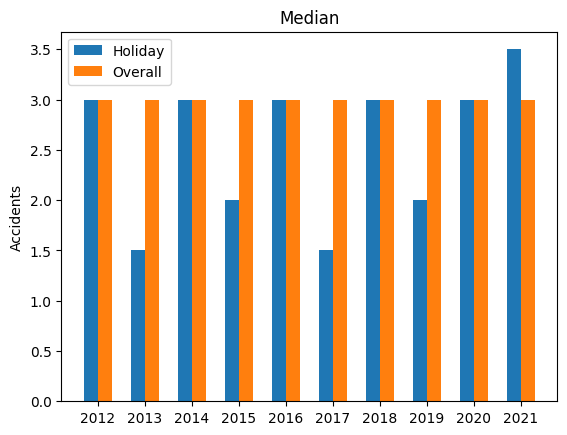

In [20]:
plt.figure(figsize=(20, 10))

x = np.arange(len(years))
width = 0.3

fig, ax = plt.subplots()
l1 = ax.bar(x- width/2, holiday_m, width, label="Holiday")
l2 = ax.bar(x+ width/2, medians, width, label="Overall")

ax.set_ylabel("Accidents")
ax.set_title("Median")
ax.set_xticks(x, years)
ax.legend()

plt.savefig("medianComparison")

plt.show()

Plot the means of all the holidays (moving and not moving) and the whole year

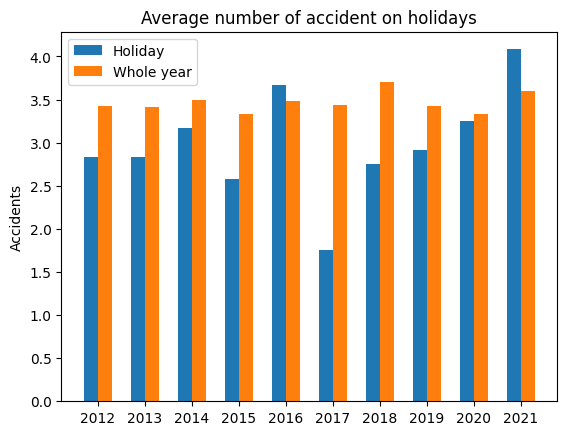

In [21]:
x = np.arange(len(years))
width = 0.3

fig, ax = plt.subplots()
l2 = ax.bar(x- width/2, holiday_means, width, label="Holiday")
l1 = ax.bar(x+ width/2, means, width, label="Whole year")

ax.set_ylabel("Accidents")
ax.set_title("Average number of accidents on holidays")
ax.set_xticks(x, years)
ax.legend()

plt.savefig("meanComparison")

plt.show()

Plot the medians of Christmas, Midsummerday, New Year's Day and the whole year

<Figure size 2000x1000 with 0 Axes>

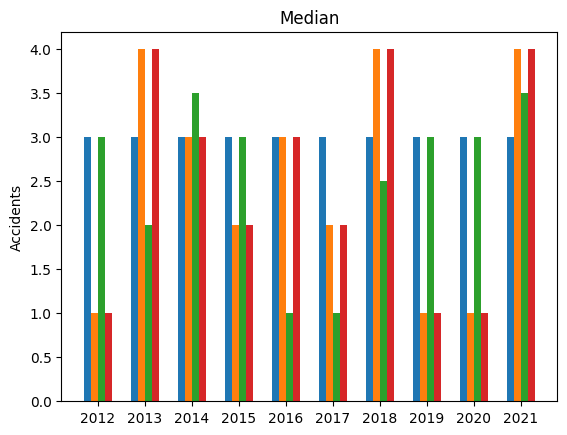

In [22]:
plt.figure(figsize=(20, 10))

x = np.arange(len(years))

width = 0.15

fig, ax = plt.subplots()
l1 = ax.bar(x- width- width/2, medians, width, label="Whole year")
l2 = ax.bar(x- width/2, christmas_m, width, label="Christmas")
l3 = ax.bar(x+ width/2, newyear_m, width, label="New Year's Day")
l4 = ax.bar(x+ width + width/2, midsummer_m, width, label="Midsummer Day")

ax.set_ylabel("Accidents")
ax.set_title("Median")
ax.set_xticks(x, years)

plt.savefig("medianHolidays")

plt.show()

Plot the means of Christmas, Midsummerday, New Year's Day and the whole year

<Figure size 2000x1000 with 0 Axes>

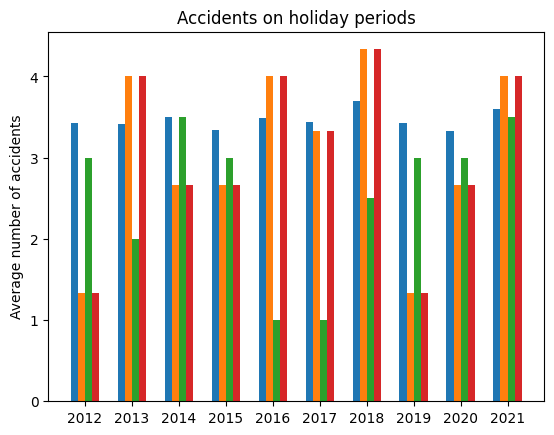

In [23]:
plt.figure(figsize=(20, 10))

x = np.arange(len(years))

width = 0.15

fig, ax = plt.subplots()
l1 = ax.bar(x- width- width/2, means, width, label="Whole year")
l2 = ax.bar(x- width/2, christmas_means, width, label="Christmas")
l3 = ax.bar(x+ width/2, newyear_means, width, label="New Year's Day")
l4 = ax.bar(x+ width + width/2, midsummer_means, width, label="Midsummer Day")

ax.set_ylabel("Average number of accidents")
ax.set_title("Accidents on holiday periods")
ax.set_xticks(x, years)

plt.savefig("meanHolidays")

plt.show()

Find the dates (day and month) with the highest number of accidents between all years

<AxesSubplot:xlabel='DM'>

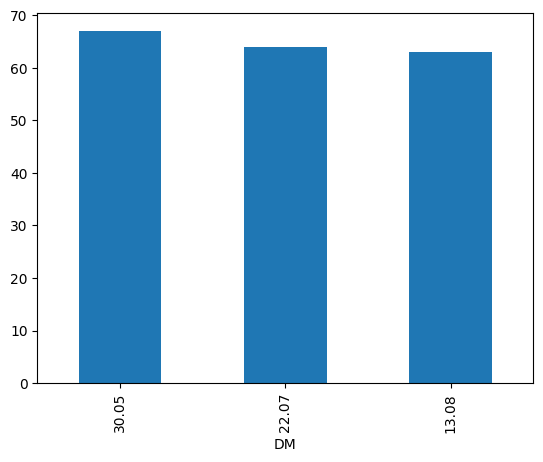

In [29]:
nonholiday_df = nonholiday_df[nonholiday_df["Year"] != "2011"]

high = nonholiday_df.value_counts("DM")[:3] #top 3 days with most accidents (all years sum)
other = nonholiday_df.value_counts("DM")[3:]

high.plot(kind="bar")